In [ ]:
!pip install gurobipy  # install gurobipy, if not already installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 60.4 MB/s eta 0:00:00


Pre-order cost per unit (b): [20 23 21 22 23]
Extra cost to complete each product (l): [55 94 67 74 69 62 93 71]
Selling cost (q): [936 939 644 870 542 526 750 983]
Extra cost - Selling cost: [-881 -845 -577 -796 -473 -464 -657 -912]
Pre-order resale costs per unit (s): [13  9  8  5 12]
Matrix A:
[[0 1 2 3 2]
 [3 2 3 0 1]
 [0 0 1 3 1]
 [3 0 0 1 0]
 [3 2 1 1 1]
 [0 1 1 1 0]
 [0 2 0 3 2]
 [1 0 2 0 1]]

Random demand matrix (p_k):
[[5 6 4 5 7 6 6 4]
 [2 6 5 3 5 2 7 6]]
Restricted license - for non-production use only - expires 2025-11-24
Optimal solution for x: [58.0, 49.0, 53.0, 63.0, 43.0]
Optimal solution for y (Scenario 1): [0.0, 0.0, 0.0, 0.0, 0.0]
Optimal solution for z (Scenario 1): [5.0, 6.0, 4.0, 5.0, 7.0, 6.0, 6.0, 4.0]
Optimal solution for y1 (Scenario 2): [10.0, 9.0, 7.0, 11.0, 3.0]
Optimal solution for z1 (Scenario 2): [2.0, 6.0, 5.0, 3.0, 5.0, 2.0, 7.0, 6.0]
Expected value: -3721.4306
Optimal value of the model: -21862.5 

Random demand matrix (p_k):
[[6 3 5 7 8 6 3 5]
 [5 1

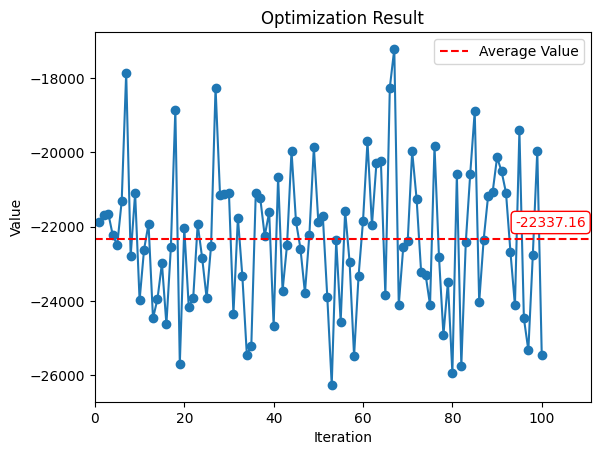

In [ ]:
# Install matplot to draw a graph
import matplotlib.pyplot as plt
import gurobipy as gp
import numpy as np
from gurobipy import GRB
from numpy import random
from array import*

# Define parameters
n = 8  # Number of products
m = 5  # Number of parts to be ordered before production

# Function to generate non-zero random matrix
def generate_non_zero_matrix(shape, max_value):
    matrix = random.randint(0, max_value + 1, size=shape)
    while np.all(matrix == 0):
        matrix = random.randint(0, max_value + 1, size=shape)
    return matrix

# Simulate data for two-stage stochastic
b_r = random.randint(10, 25, m)  # Random data for pre-order cost per unit
l_r = random.randint(50, 100, n)   # Random data for extra cost to complete each product
q_r = random.randint(500, 1000, n)    # Random data for selling cost
s_r = random.randint(5, 15, m)    # Random data for pre-order resale costs per unit
A_r = generate_non_zero_matrix((n, m), 3)  # Random data for the matrix A

# Ensure that b[j] is always greater than s[j]
for j in range(m):
    while b_r[j] <= s_r[j]:
        b_r[j] = random.randint(10, 25)

print(f"Pre-order cost per unit (b): {b_r}")
print(f"Extra cost to complete each product (l): {l_r}")
print(f"Selling cost (q): {q_r}")
print(f"Extra cost - Selling cost: {l_r - q_r}")
print(f"Pre-order resale costs per unit (s): {s_r}")
print(f"Matrix A:\n{A_r}\n")

# Simulate random demand vectors for each scenario
S = 2  # Number of scenarios
p_s = 1 / 2  # Probability for each scenario

result = np.zeros(100)
result_x = np.zeros((100, 5))

for index in range(100):
  b = b_r
  l = l_r
  q = q_r
  s = s_r
  A = A_r

  p_k = random.binomial(10, 0.5, size=(S, n))

  # Normalize the demand vectors for each scenario
  p_k_normalized = np.apply_along_axis(lambda x: x / np.sum(x), axis=1, arr=p_k)

  print(f"Random demand matrix (p_k):\n{p_k}")

  M = gp.Model("2Stage-SPL")
  x = M.addVars(m, name="x", vtype=GRB.INTEGER)
  # Scenario 1
  y = M.addVars(m, name="y", vtype=GRB.INTEGER)
  z = M.addVars(n, name="z", vtype=GRB.INTEGER)
  # Scenario 2
  y1 = M.addVars(m, name="1", vtype=GRB.INTEGER)
  z1 = M.addVars(n, name="2", vtype=GRB.INTEGER)

  M.Params.OutputFlag = 0
  M.setParam('OutputFlag', 0)  # Telling gurobi to not be verbose
  M.params.logtoconsole = 0

  # Constraints
  for i in range(n):
        M.addConstr(z[i] <= p_k[0, i])
        M.addConstr(z1[i] <= p_k[1, i])
        M.addConstr(z[i] >= 0)
        M.addConstr(z1[i] >= 0)

  for j in range(m):
        M.addConstr(y[j] == x[j] - gp.quicksum(A[i, j] * z[i] for i in range(n)))
        M.addConstr(y[j] >= 0)
        M.addConstr(y1[j] == x[j] - gp.quicksum(A[i, j] * z1[i] for i in range(n)))
        M.addConstr(y1[j] >= 0)
        M.addConstr(x[j] >= 0)

  # Objective function
  M.setObjective(
      gp.quicksum(b[j] * x[j] for j in range(m))
      + p_s * ( gp.quicksum( (l[i] - q[i]) * z[i] for i in range(n) ) - gp.quicksum( s[j] * y[j] for j in range(m) ) )    # Scenario 1
      + p_s * ( gp.quicksum( (l[i] - q[i]) * z1[i] for i in range(n) ) - gp.quicksum( s[j] * y1[j] for j in range(m) ) )  # Scenario 2
      , GRB.MINIMIZE)

  # Solve the model
  M.optimize()

  # Get the optimal solution
  optimal_x = [var.x for var in M.getVars() if var.varName.startswith('x')]
  optimal_y = [var.x for var in M.getVars() if var.varName.startswith('y')]
  optimal_z = [var.x for var in M.getVars() if var.varName.startswith('z')]
  optimal_y1 = [var.x for var in M.getVars() if var.varName.startswith('1')]
  optimal_z1 = [var.x for var in M.getVars() if var.varName.startswith('2')]

  # Initialize E_Z
  E_Z = 0

  # Calculate the expected value, the average value of products in both scenarios
  for i in range(n):
      E_Z += p_s * p_k_normalized[0, i] * (l[i] - q[i]) * optimal_z[i]
      E_Z += p_s * p_k_normalized[1, i] * (l[i] - q[i]) * optimal_z1[i]

  # Print the results
  result_x[index] = optimal_x # Save optimal_x values
  print(f"Optimal solution for x: {optimal_x}")

  print(f"Optimal solution for y (Scenario 1): {optimal_y}")
  print(f"Optimal solution for z (Scenario 1): {optimal_z}")
  print(f"Optimal solution for y1 (Scenario 2): {optimal_y1}")
  print(f"Optimal solution for z1 (Scenario 2): {optimal_z1}")
  print(f"Expected value: {round(E_Z, 4)}")

  result[index] = M.objVal # Save optimal value of the model
  print(f"Optimal value of the model: {result[index]} \n")

Average_optimal_x = np.zeros(5);
for index in range(100):
    Average_optimal_x += result_x[index]

Average_optimal_x = Average_optimal_x / 100
Total_cost_order = 0
for index in range(m):
    print(f"\nAverage cost to order parts type {index} is: {round(Average_optimal_x[index]) * b[index]}, and the number of pre-ordered parts is: {round(Average_optimal_x[index])}")
    Total_cost_order += round(Average_optimal_x[index]) * b[index]

print(f"\nTotal cost required to order: {Total_cost_order}")

Average_optimal_value = 0;
for index in range(100):
    Average_optimal_value += result[index]

Average_optimal_value = Average_optimal_value / 100
print(f"\nAverage value of the objective function: {Average_optimal_value}")

# Draw chart to show clearly the optimal cost
result = np.insert(result, 0, np.nan) # Start with 1
plt.plot(result, marker='o', linestyle='-')
plt.axhline(y=Average_optimal_value, color='red', linestyle='--', label='Average Value')
plt.xlim(0, len(result) + 10)

# Show the average value
plt.annotate(f'{Average_optimal_value:.2f}',
             xy=(len(result) + 3, Average_optimal_value),
             xytext=(len(result) + 1, Average_optimal_value + 260),
             ha='center', va='bottom', color='red', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='red', facecolor='white'))

plt.legend() # Display caption

plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Optimization Result')

plt.show()